# Dataset download

[link here](https://github.com/DonsetPG/narya)

In [ ]:
from bs4 import BeautifulSoup 
import os
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k


root=r"../input/footballlandmarks/Football landMarks/"
train_imgs_path=root+r"train/JPEGImages/"
train_anno_path=root+r"train/Annotations/"
test_imgs_path=root+r"test/JPEGImages/"
test_anno_path=root+r"test/Annotations/"

***CONVERTING DATA TO NUMPY ARRAYS***

In [ ]:
def read_anno(path):
    with open(path, 'r') as f:
        data = f.read()
        
        
    Bs_data = BeautifulSoup(data, "lxml")
     
    
    b_unique = Bs_data.find_all('object')
     
    annos={}
    for obj in b_unique:
        name=int(obj.find('name').text)
        x=int(obj.find('x1').text)
        y=int(obj.find('y1').text)
        annos[name]=[x,y]
    return annos

def draw_anno(img,anno):
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 2
    
    xx=img.copy()

    for key, value in anno.items():
        x1= value[0]
        y1= value[1]

        cv2.circle(xx,(x1,y1),2,(1,1,1),-1)
        cv2.putText(xx,str(key), 
        (x1,y1), 
        font, 
        fontScale,
        fontColor,
        lineType)
    return xx   

In [ ]:
##############################################  read train
train_imgs=[]
train_anno=[]
for file in os.listdir(train_imgs_path):
    if file[-4:] != ".jpg":
        continue

    img=cv2.imread(train_imgs_path+file)
    anno=read_anno(train_anno_path+file[:-4]+'.xml')
    y_anno=np.full((29, 2), -1)

    for key , value in anno.items():
        y_anno[key,0]=value[0]
        y_anno[key,1]=value[1]
    train_imgs.append(img)
    train_anno.append(y_anno)
train_imgs=np.array(train_imgs)
train_anno=np.array(train_anno)


##############################################  read test
test_imgs=[]
test_anno=[]
for file in os.listdir(test_imgs_path):
    if file[-4:] != ".jpg":
        continue

    img=cv2.imread(test_imgs_path+file)
    anno=read_anno(test_anno_path+file[:-4]+'.xml')
    y_anno=np.full((29, 2), -1)

    for key , value in anno.items():
        y_anno[key,0]=value[0]
        y_anno[key,1]=value[1]
    test_imgs.append(img)
    test_anno.append(y_anno)
    
test_imgs=np.array(test_imgs)
test_anno=np.array(test_anno)

In [ ]:
print('trainx shape',train_imgs.shape)
print('trainy shape',train_anno.shape)
print('testx shape',test_imgs.shape)
print('testy shape',test_anno.shape)

trainx shape (507, 320, 320, 3)
trainy shape (507, 29, 2)
testx shape (58, 320, 320, 3)
testy shape (58, 29, 2)


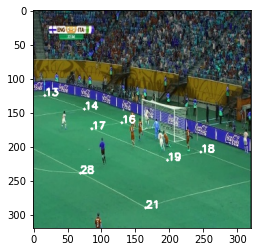

In [ ]:
def plot_somepoints(x,y,i=5):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 2
    xx=x[i].copy()/255.0
    yy=y[i]
    for p in range(29):
        x1= int(yy[p,0])
        y1= int(yy[p,1])
        if x1 < 0:
            continue
        cv2.circle(xx,(x1,y1),2,(1,1,1),-1)
        cv2.putText(xx,str(p), 
        (x1,y1), 
        font, 
        fontScale,
        fontColor,
        lineType)

    plt.imshow(xx)
plot_somepoints(train_imgs,train_anno,300)

In [ ]:
x=np.concatenate((train_imgs,test_imgs))
y=np.concatenate((train_anno,test_anno))

**resize image to 160*160 and land marks**

In [ ]:
shape1 = x.shape[1]
shape2=160
f = shape1/shape2

x160=np.zeros((x.shape[0],160,160,3),dtype=np.uint8)
y160=np.zeros((x.shape[0],29,2),dtype=np.float32)

for xw in range(y.shape[0]):
    img=cv2.resize(x[xw],(160,160))
    x160[xw]=img
    for yw in range(y.shape[1]):
        if y[xw,yw,0] !=-1:
            xc1=int(np.trunc(((y[xw,yw,0])/f)))
            yc1=int(np.trunc(((y[xw,yw,1])/f)))
            y160[xw,yw,0] =xc1
            y160[xw,yw,1] =yc1
        else :
            y160[xw,yw,0] =-1
            y160[xw,yw,1] =-1

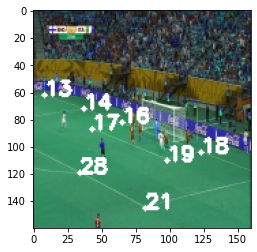

In [ ]:
plot_somepoints(x160,y160,300)

**convert the land marks coordinates in the x data (160,160,3)
to y data (40,40,30)**

In [ ]:
shape1 = x160.shape[1]
shape2 = 40
f = shape1/shape2

ye=np.zeros((x160.shape[0],40,40,1),dtype=np.float32)
for xw in range(y160.shape[0]):
    for yw in range(y160.shape[1]):
        if y160[xw,yw,0] !=-1:
            index=(yw+1)
            #(y[xw,yw,0]-1) -> to make land marks with zero indexing 
            xc=int(np.trunc((y160[xw,yw,0]-1)/f))
            yc=int(np.trunc((y160[xw,yw,1]-1)/f))
            ye[xw,yc,xc,0] =index

In [ ]:
x160=x160.astype(np.float32)

In [ ]:
print(ye.shape)
print(ye.dtype)
print(x160.shape)
print(x160.dtype)

(565, 40, 40, 1)
float32
(565, 160, 160, 3)
float32


**class weighting**

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(ye.reshape(-1)),
                                                 ye.reshape(-1))
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# i will use one hot encoder in the next step
we=np.zeros((ye.shape[0],40,40,1),dtype=np.float32)
for im in range(ye.shape[0]):
    for xw in range(ye.shape[1]):
        for yw in range(ye.shape[2]):
            v=ye[im,xw,yw,0]
            we[im,xw,yw,0] =class_weight_dict[v]

yee=to_categorical(ye,num_classes=30)
yd=np.concatenate((yee, we), axis=-1)
xe=x160.astype(np.float32)/255.0

In [ ]:
input = tf.keras.layers.Input((160,160,3))
l = tf.keras.layers.Conv2D(128,(5,5),padding='same',strides=(2,2),activation='relu')(input)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(128,(5,5),padding='same',strides=(2,2),activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l1 = tf.keras.layers.Conv2D(30,(3,3),padding='same',activation='softmax')(l)
model=tf.keras.Model(input,l1)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 80, 128)       9728      
_________________________________________________________________
batch_normalization_4 (Batch (None, 80, 80, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 128)       409728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 40, 40, 128)       0   

In [ ]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
def my_loss_fn(ytrue, ypred ):
    yp=k.reshape(ypred,(-1,30))
    yt=k.reshape(ytrue[:,:,:,:-1],(-1,30))
    wed=k.reshape(ytrue[:,:,:,-1],(-1,1))
    lose1= tf.keras.losses.categorical_crossentropy(yt,yp)
    losetotal=k.sum(wed*lose1)
    return losetotal

In [ ]:
epochs =150
for e in range(epochs):
    lol =0
    kk=0
    for b in range(0,xe.shape[0],5):
        xb=xe[b:b+5]
        yb=yd[b:b+5]
        with tf.GradientTape() as tape:
            y_pred=model(xb,training=True)
            l=my_loss_fn(yb,y_pred)
        gf=tape.gradient(l,model.trainable_variables)
        opt1.apply_gradients(zip(gf,model.trainable_variables)) 
        lol = l+lol
        kk+=1
    print(e)
    print('loss',lol/kk)

0
loss tf.Tensor(59826.223, shape=(), dtype=float32)
1
loss tf.Tensor(43628.344, shape=(), dtype=float32)
2
loss tf.Tensor(25254.469, shape=(), dtype=float32)
3
loss tf.Tensor(12364.365, shape=(), dtype=float32)
4
loss tf.Tensor(7776.3457, shape=(), dtype=float32)
5
loss tf.Tensor(6250.837, shape=(), dtype=float32)
6
loss tf.Tensor(4933.3706, shape=(), dtype=float32)
7
loss tf.Tensor(4630.654, shape=(), dtype=float32)
8
loss tf.Tensor(4096.9663, shape=(), dtype=float32)
9
loss tf.Tensor(5509.072, shape=(), dtype=float32)
10
loss tf.Tensor(3895.247, shape=(), dtype=float32)
11
loss tf.Tensor(3470.3186, shape=(), dtype=float32)
12
loss tf.Tensor(4429.9897, shape=(), dtype=float32)
13
loss tf.Tensor(3382.6575, shape=(), dtype=float32)
14
loss tf.Tensor(3848.4773, shape=(), dtype=float32)
15
loss tf.Tensor(2819.2158, shape=(), dtype=float32)
16
loss tf.Tensor(2726.1416, shape=(), dtype=float32)
17
loss tf.Tensor(2493.5195, shape=(), dtype=float32)
18
loss tf.Tensor(3537.3848, shape=(), dty

**predicting**

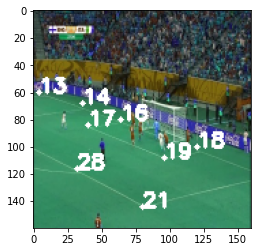

In [ ]:
img=xe[300]
clas=model.predict((img.reshape((1,160,160,3))))
clase=np.argmax(clas[0],axis=-1)
cop=img.copy()
for y in range(40):
    for x in range(40):
        if clase[y,x] > 0 and clas[0,y,x,clase[y,x]] >0.6:
            yee=y*4
            xee=x*4
            cv2.circle(cop,(xee,yee),2,(1,1,1),-1)
            cv2.putText(cop,str(clase[y,x]-1), 
            (xee,yee), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5,
            (1,1,1),
             2)
plt.imshow(cop)
plt.show()